In [110]:
import numpy as np
import pandas as pd
import requests
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(123)

# Categorical Encoding

In [56]:
# Load your generated data
df = pd.read_csv("Yield_shelile.csv")

# Encode categorical features (village and crop_type)
village_encoder = LabelEncoder()
df['village_encoded'] = village_encoder.fit_transform(df['village'])

crop_encoder = LabelEncoder()
df['crop_type_encoded'] = crop_encoder.fit_transform(df['crop_type'])
df.head(2)

,Unnamed: 0,village,timestamp,crop_type,total_yield,pesticides_tonnes,rainfall_mm,temperature_C,humidity_%,wind_speed_kmph,...,local_market_demand_tonnes,export_market_demand_tonnes,local_market_price_Maloti_per_tonne,export_market_price_Maloti_per_tonne,storage_cost_Maloti_per_month,transport_cost_Maloti_per_km,profit_margin_%,supply_vs_demand_ratio,village_encoded,crop_type_encoded
0,0,Thaba-Tseka,2020-01-31,wheat,8.08987,4.893046,145.975084,16.929255,65.696400,12.924528,...,2194.938184,1307.779627,2345.457957,6922.969040,238.905260,37.705094,5.002796,1.274152,4,2
1,1,Semonkong,2020-02-29,wheat,7.92908,4.649022,100.097834,31.787334,64.309958,8.381335,...,658.217938,969.927378,2610.217763,6012.231565,428.743783,20.621525,16.424340,0.682203,3,2


# Drop unwanted Features

In [57]:
unwanted = [
    'Unnamed: 0',
    "village",
    "crop_type",
    "soil_ph",
    "soil_moisture_%",
    "soil_nitrogen_ppm",
    "soil_phosphorus_ppm",
    "soil_potassium_ppm",
    "organic_matter_%",
    
    "local_market_demand_tonnes",
    "export_market_demand_tonnes",
    "local_market_price_Maloti_per_tonne",
    "export_market_price_Maloti_per_tonne",
    "storage_cost_Maloti_per_month",
    "transport_cost_Maloti_per_km",
    "profit_margin_%",
    "supply_vs_demand_ratio",

    # "fertilizer_kg_per_hectare",
    "irrigation_mm",
    "pesticide_use_liters",
    "NDVI",
    "EVI",
    "SAVI",
    "canopy_temp_C",
    "previous_yield_tonnes",
    "yield_variability_%",
    "market_price_usd_per_tonne",
    "demand_forecast_tonnes",
    "altitude_m",
    "slope_%",
    "proximity_to_water_km",
    # "drought_frequency",
    "heatwave_days",
    "CO2_concentration_ppm",
    # "pesticides_tonnes"
    ]

df.drop(columns=unwanted,inplace=True)

In [58]:
df.columns

Index(['timestamp', 'total_yield', 'pesticides_tonnes', 'rainfall_mm',
       'temperature_C', 'humidity_%', 'wind_speed_kmph', 'solar_radiation_Wm2',
       'frost_days', 'fertilizer_kg_per_hectare', 'drought_frequency',
       'village_encoded', 'crop_type_encoded'],
      dtype='object')

In [59]:
numerical_features = ['total_yield', 'pesticides_tonnes',
       'rainfall_mm', 'temperature_C', 'humidity_%', 'wind_speed_kmph',
       'solar_radiation_Wm2', 'frost_days', 'fertilizer_kg_per_hectare',
       'drought_frequency', 'village_encoded', 'crop_type_encoded']

In [60]:
# Scale the numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [93]:
# Sort by timestamp to maintain time order
df = df.sort_values(by=['timestamp'])

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    # Loop through the dataset
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]  # Slice the sequence for input
        target = data[i + sequence_length][-1]  # Assuming the target 'total_yield' is the last column
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [94]:
df.head()

,timestamp,pesticides_tonnes,rainfall_mm,temperature_C,humidity_%,wind_speed_kmph,solar_radiation_Wm2,frost_days,fertilizer_kg_per_hectare,drought_frequency,village_encoded,crop_type_encoded,total_yield
0,2020-01-31,1.538343,0.490470,-1.458359,0.041130,0.022050,0.612634,-1.519398,1.478511,1.257417,1.490484,1.224745,0.862084
56,2020-01-31,-1.646278,-0.660776,-0.519835,1.109209,0.334282,0.068339,-1.519398,0.789758,-0.007529,1.490484,0.000000,0.343301
112,2020-01-31,-1.590788,1.593417,0.450222,1.285238,1.169775,-0.000632,1.262715,1.062914,-1.272476,1.490484,-1.224745,1.532932
1,2020-02-29,1.352591,-0.611848,1.127116,-0.053027,-1.016216,-1.358603,0.567187,-1.509083,-1.272476,0.731692,1.224745,0.792265
57,2020-02-29,1.343932,0.899926,-0.932962,0.537576,0.590278,-0.597025,1.262715,0.349410,-1.272476,0.731692,0.000000,0.501580


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  168 non-null    object 
 1   pesticides_tonnes          168 non-null    float64
 2   rainfall_mm                168 non-null    float64
 3   temperature_C              168 non-null    float64
 4   humidity_%                 168 non-null    float64
 5   wind_speed_kmph            168 non-null    float64
 6   solar_radiation_Wm2        168 non-null    float64
 7   frost_days                 168 non-null    float64
 8   fertilizer_kg_per_hectare  168 non-null    float64
 9   drought_frequency          168 non-null    float64
 10  village_encoded            168 non-null    float64
 11  crop_type_encoded          168 non-null    float64
 12  total_yield                168 non-null    float64
dtypes: float64(12), object(1)
memory usage: 18.4+ KB


In [96]:
df.describe()

,pesticides_tonnes,rainfall_mm,temperature_C,humidity_%,wind_speed_kmph,solar_radiation_Wm2,frost_days,fertilizer_kg_per_hectare,drought_frequency,village_encoded,crop_type_encoded,total_yield
count,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02
mean,-1.321694e-16,-2.643388e-16,1.015061e-15,-4.493760e-16,2.326182e-16,-3.780045e-16,1.533165e-16,2.590520e-16,2.643388e-17,6.872809e-17,-2.643388e-18,-4.335157e-16
std,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00
min,-1.801694e+00,-1.811284e+00,-1.772216e+00,-1.658017e+00,-1.767338e+00,-1.728951e+00,-1.519398e+00,-1.587468e+00,-1.272476e+00,-1.544683e+00,-1.224745e+00,-1.736683e+00
25%,-8.386378e-01,-9.216761e-01,-9.214498e-01,-9.338927e-01,-9.059933e-01,-8.481708e-01,-8.238700e-01,-8.174797e-01,-1.272476e+00,-7.858915e-01,-1.224745e+00,-9.299513e-01
50%,7.182602e-02,1.037064e-01,7.388962e-02,8.851063e-02,-7.164325e-02,-3.899085e-02,-1.283416e-01,-9.831447e-02,-7.529446e-03,-2.709971e-02,0.000000e+00,9.063363e-02
75%,8.711191e-01,8.643725e-01,8.513909e-01,8.352352e-01,9.588025e-01,6.930097e-01,5.671869e-01,7.947607e-01,1.257417e+00,7.316921e-01,1.224745e+00,8.406327e-01
max,1.616245e+00,1.723231e+00,1.636924e+00,1.688386e+00,1.629260e+00,1.920080e+00,1.262715e+00,1.836881e+00,1.257417e+00,1.490484e+00,1.224745e+00,1.584175e+00


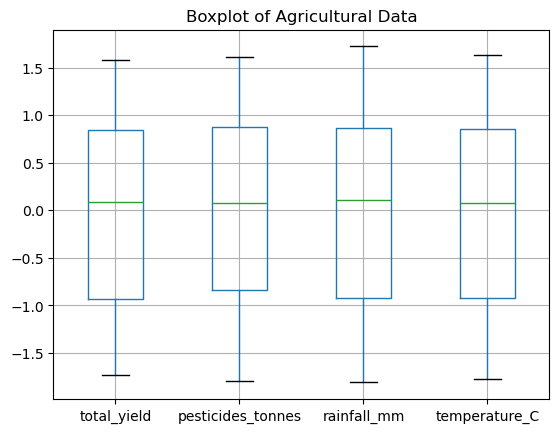

In [97]:
df[['total_yield', 'pesticides_tonnes', 'rainfall_mm', 'temperature_C']].boxplot()

plt.title('Boxplot of Agricultural Data')

plt.show()

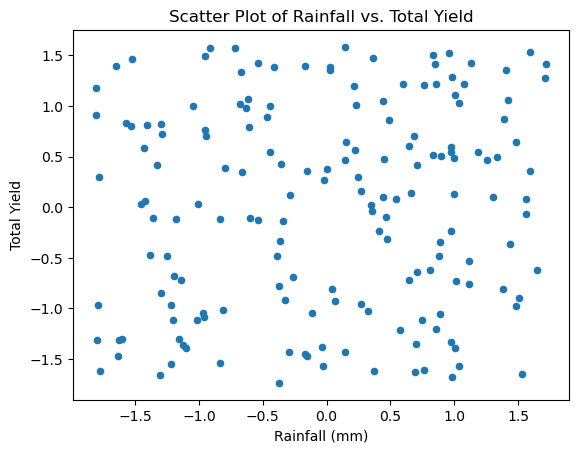

In [98]:
df.plot.scatter(x='rainfall_mm', y='total_yield')

plt.title('Scatter Plot of Rainfall vs. Total Yield')

plt.xlabel('Rainfall (mm)')

plt.ylabel('Total Yield')

plt.show()

In [99]:


columns = [col for col in df.columns if col != 'total_yield'] + ['total_yield']
df = df[columns]
df

,timestamp,pesticides_tonnes,rainfall_mm,temperature_C,humidity_%,wind_speed_kmph,solar_radiation_Wm2,frost_days,fertilizer_kg_per_hectare,drought_frequency,village_encoded,crop_type_encoded,total_yield
0,2020-01-31,1.538343,0.490470,-1.458359,0.041130,0.022050,0.612634,-1.519398,1.478511,1.257417,1.490484,1.224745,0.862084
56,2020-01-31,-1.646278,-0.660776,-0.519835,1.109209,0.334282,0.068339,-1.519398,0.789758,-0.007529,1.490484,0.000000,0.343301
112,2020-01-31,-1.590788,1.593417,0.450222,1.285238,1.169775,-0.000632,1.262715,1.062914,-1.272476,1.490484,-1.224745,1.532932
1,2020-02-29,1.352591,-0.611848,1.127116,-0.053027,-1.016216,-1.358603,0.567187,-1.509083,-1.272476,0.731692,1.224745,0.792265
57,2020-02-29,1.343932,0.899926,-0.932962,0.537576,0.590278,-0.597025,1.262715,0.349410,-1.272476,0.731692,0.000000,0.501580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2024-07-31,-0.298862,0.857504,0.030726,0.869312,1.003118,-0.525216,1.262715,-0.566326,-0.007529,-0.027100,-1.224745,1.218915
110,2024-07-31,-0.188250,0.413504,-1.743992,-1.323619,1.426653,-1.157330,0.567187,0.155779,-1.272476,-0.785892,0.000000,-0.232884
55,2024-08-31,1.025491,1.006379,1.613054,-1.580402,-0.337108,-0.580864,-0.823870,0.847430,-1.272476,0.731692,1.224745,1.112611
111,2024-08-31,0.017144,-1.181750,0.317967,0.952898,-0.405764,0.123426,-0.128342,1.579247,-1.272476,0.731692,0.000000,-0.117492


In [101]:
sequence_length = 30  # Use the past 30 months for prediction
X, y = create_sequences(df[numerical_features].values, sequence_length)

In [102]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes of the splits
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (110, 30, 12)
Test data shape: (28, 30, 12)


In [103]:
# Reshape data for LSTM: [samples, timesteps, features]
# X_train shape before reshaping: (number_of_samples, sequence_length, number_of_features)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Check the shapes
print(f"X_train reshaped shape: {X_train_reshaped.shape}")
print(f"X_test reshaped shape: {X_test_reshaped.shape}")


X_train reshaped shape: (110, 30, 12)
X_test reshaped shape: (28, 30, 12)


In [104]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))  # Output layer predicting 'total_yield'



/home/ghost/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model and save the training history
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - loss: 0.9922 - val_loss: 0.9671
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0022 - val_loss: 0.9656
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0434 - val_loss: 0.9653
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0262 - val_loss: 0.9644
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9471 - val_loss: 0.9646
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.9538 - val_loss: 0.9630
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9766 - val_loss: 0.9607
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.9419 - val_loss: 0.9586
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.0089 - val_loss: 0.9558
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9563 - val_loss: 0.9538


In [106]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test MSE: {test_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.0817
Test MSE: 1.0816705226898193


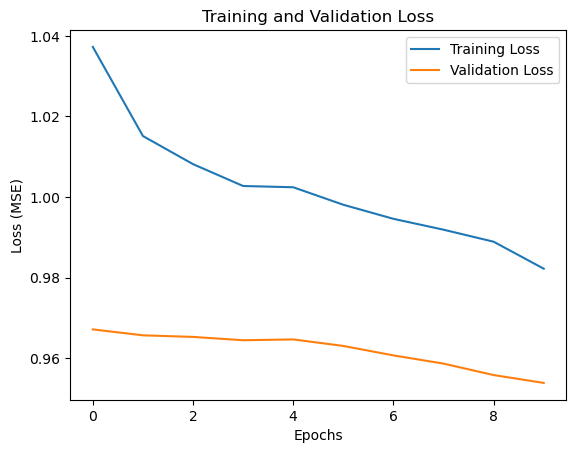

In [107]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [111]:
#  Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping and validation
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/100


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.9063 - val_loss: 1.0905
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.9743 - val_loss: 1.1077
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.9471 - val_loss: 1.1297
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.9153 - val_loss: 1.1447
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8967 - val_loss: 1.1647
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.9280 - val_loss: 1.1716


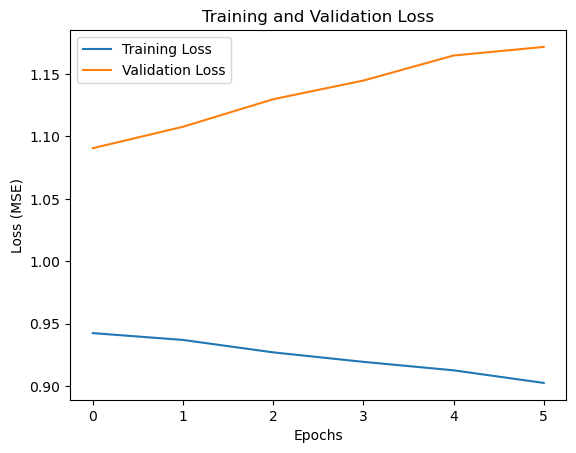

In [112]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()
